In [1]:
import timeit
from datetime import timedelta
import math
import numpy as np
from scipy.linalg import toeplitz
import pandas as pd
# from pandas_profiling import ProfileReport
# import lux # slows down dataframe processing
import matplotlib.pyplot as plt
%matplotlib inline
import joblib

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, StratifiedKFold, HalvingGridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

np.set_printoptions(suppress=True) # do not print scientific notation

# Set some matplotlib style parameters
plt.style.use('seaborn')
plt.rcParams.update({'figure.facecolor' : 'white',
                     'figure.edgecolor' : 'white',
                     'axes.grid'        : True,
                     # 'axes.axisbelow'   : True,
                     'figure.autolayout': True # tight_layout
                    })

# Set some pandas options
pd.set_option('display.max_columns', None, # show x columns (None shows all)
              # 'display.max_rows', None,  # show x rows    (None shows all)
              'compute.use_numba', True)   # turn off for Lux

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
nb_name = 'more_1s_than_0s' # for saving objects with joblib
seed = 42
rng = np.random.default_rng(seed)

n = secure_bits = 32        # rows
m = corrected_key_bits = 64 # columns
N_vec = 10000               # nº of corrected key vectors

## Functions

### Generate modified Toeplitz matrix

In [3]:
def get_modified_Toeplitz(seed_):
    mat1 = toeplitz(seed_[:n], seed_[n-1:])
    mat2 = np.eye(n, dtype=np.int8)
    return np.concatenate((mat1, mat2), axis=1)

### Detect power consumption of basic gates

In [4]:
def get_product_power(mat, vec, gate_powers, noise_std=0.):
    '''Returns: array with the power consumed by the gates of each product.
    Set noise_std = 0 to eliminate noise.'''
    n, m = mat.shape
    count = [[] for _ in range(n)]
    for i in range(n):
        for j in range(m):
            idx = 2 * mat[i, j] + vec[j]
            count[i].extend(gate_powers[idx] + rng.normal(scale=noise_std, size=gate_powers[idx].size))
    return count # size = n * m * gate_powers[idx].size

In [5]:
def get_sum_power(mat, vec, gate_powers, noise_std=0.):
    '''Returns: array with the power consumed by the gates of each sum.
    Set noise_std = 0 to eliminate noise.'''
    n, m = mat.shape
    count = [[] for _ in range(n)]
    for i in range(n):
        result = 0
        for j in range(m):
            next_element = mat[i, j] * vec[j]
            idx = 2 * result + next_element
            count[i].extend(gate_powers[idx] + rng.normal(scale=noise_std, size=gate_powers[idx].size))
            result = (result + next_element) % 2
    return count # size = n * m * gate_powers[idx].size

In [6]:
# # TEST
# mat = np.asarray([[0, 1, 1, 0, 1],
#                   [1, 0, 1, 1, 1],
#                   [1, 1, 1, 1, 1],
#                   [0, 0, 0, 0, 0]])
# # vec = np.asarray([0, 0, 0, 0, 0])
# # vec = np.asarray([1, 1, 1, 1, 1])
# vec = np.asarray([1, 1, 1, 0, 0])
# power_products = np.asarray([[.1, 1.1], [.2, 1.2], [.3, 1.3], [.4, 1.4]])
# power_sums = np.asarray([[1.1, 2.1], [1.2, 2.2], [1.3, 2.3], [1.4, 2.4]])

# print(mat @ vec % 2, '\n')
# count = get_product_power(mat, vec, power_products, 0.01)
# print(np.around(count, 3), '\n')
# count = get_sum_power(mat, vec, power_sums, 0.01)
# print(np.around(count, 3))

### Class

In [7]:
# Detect if there are more 1s than 0s
def More_1_than_0(mat, vec):
    return np.sum(mat @ vec % 2) > secure_bits / 2

### Other

In [8]:
# Check if input & output vectors from sample are unique
def Check_uniqueness(mat, vec):
    res = []
    for i in range(len(vec)):
        res.append(mat @ vec[i] % 2)
    unique_in  = np.unique(vec, axis=0)
    unique_out = np.unique(res, axis=0)
    return unique_in.shape[0], unique_out.shape[0]

## Generate data

In [9]:
# mat = rng.integers(2, size=(secure_bits,corrected_key_bits), dtype=np.int8)
mat = get_modified_Toeplitz(rng.integers(2, size=corrected_key_bits-1, dtype=np.int8))

mat.shape, mat

((32, 64),
 array([[1, 1, 1, ..., 0, 0, 0],
        [0, 1, 1, ..., 0, 0, 0],
        [1, 0, 1, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 1, 0, 0],
        [1, 1, 0, ..., 0, 1, 0],
        [1, 1, 1, ..., 0, 0, 1]], dtype=int8))

In [10]:
vec = [rng.integers(2, size=corrected_key_bits, dtype=np.int8) for _ in range(N_vec)]

np.shape(vec), vec[0]

((10000, 64),
 array([0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
        0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int8))

In [43]:
unique_in, unique_out = Check_uniqueness(mat, vec)
print(f'{N_vec} inputs: {unique_in} unique inputs, {unique_out} unique solutions')

10000 inputs: 10000 unique inputs, 10000 unique solutions


Assumptions on power consumption (based on https://ieeexplore.ieee.org/document/6644863):
- NOT:
    - 0 - 6.73 pA
    - 1 - 7.45 pA
- 2-input NOR:
    - 00 - 13.50 pA
    - 01 - 12.80 pA
    - 10 - &nbsp; 7.93 pA
    - 11 - &nbsp; 5.93 pA
- 2-input NAND:
    - 00 - &nbsp; 5.79 pA
    - 01 - &nbsp; 7.00 pA
    - 10 - 11.77 pA
    - 11 - 14.91 pA

Writing our operations in the gates above:
- A\*B &nbsp;= AND(A, B)
= NOT(NAND(A, B))

- A+B = XOR(A, B)
= NOT(A<=>B)
= NOT(AND(A->B, B->A))
= NAND(A->B, B->A)
= NAND(OR(NOT(A), B), OR(NOT(B), A)) =  
&nbsp; &nbsp; &nbsp; &nbsp; = NAND(NOT(NOR(NOT(A), B)), NOT(NOR(NOT(B), A)))

Thus:
- 0\*0: &nbsp; &nbsp; 5.79 + 7.45 = 13.24 pA
- 0\*1: &nbsp; &nbsp; 7.00 + 7.45 = 14.45 pA
- 1\*0: &nbsp; 11.77 + 7.45 = 19.22 pA
- 1\*1: &nbsp; 14.91 + 6.73 = 21.64 pA


- 0+0: &nbsp; 6.73 + 6.73 + &nbsp; 7.93 + &nbsp; 7.93 + 6.73 + 6.73 + 14.91 = 57.69 pA
- 0+1: &nbsp; 6.73 + 7.45 + &nbsp; 5.93 + 13.50 + 6.73 + 7.45 + 11.77 = 59.56 pA
- 1+0: &nbsp; 7.45 + 6.73 + 13.50 + &nbsp; 5.93 + 7.45 + 6.73 + &nbsp; 7.00 = 54.79 pA
- 1+1: &nbsp; 7.45 + 7.45 + 12.80 + 12.80 + 6.73 + 6.73 + 14.91 = 68.87 pA

In [10]:
# Define power consumption for each gate & noise level
power_product_gates = np.asarray([[5.79, 7.45], [7., 7.45], [11.77, 7.45], [14.91, 6.73]]) # 0*0, 0*1, 1*0, 1*1
power_sum_gates = np.asarray([[6.73, 6.73, 7.93, 7.93, 6.73, 6.73, 14.91],  # '0+0' gates
                              [6.73, 7.45, 5.93, 13.5, 6.73, 7.45, 11.77],  # '0+1' gates
                              [7.45, 6.73, 13.5, 5.93, 7.45, 6.73, 7.],     # '1+0' gates
                              [7.45, 7.45, 12.8, 12.8, 6.73, 6.73, 14.91]]) # '1+1' gates
noise_std = 0.05 + 0.0 # article measurement precision + hacker device noise

In [12]:
# i = 0
# print('Products:\n', np.around(get_product_power(mat, vec[i], power_product_gates, noise_std), 3))
# print('Sums:\n', np.around(get_sum_power(mat, vec[i], power_sum_gates, noise_std), 3))

In [13]:
# print("#1 > #0?")
# print("--------")
# for i in range(10):
#     print(More_1_than_0(mat, vec[i]), '\t', mat @ vec[i] % 2)

In [11]:
# Order data by time (row by row)
data = [[] for _ in range(N_vec)]
for i in range(N_vec):
    product_power = get_product_power(mat, vec[i], power_product_gates, noise_std)
    sum_power     = get_sum_power(mat, vec[i], power_sum_gates, noise_std)
    for j in range(n):
        data[i].extend(product_power[j])
        data[i].extend(sum_power[j])
    data[i].append(More_1_than_0(mat, vec[i]))

data = np.asarray(data)
data.shape

(10000, 1153)

In [15]:
# # Wrong model - Lower data sampling (does not work if sampling_interval does not divide data.shape[1])
# sampling_interval = 2 # in gates
# data_low_sampling = np.sum([data[:, i:-1:sampling_interval] for i in range(sampling_interval)], axis=0)
# data_low_sampling = np.append(data_low_sampling, data[:, [-1]], axis=1)

# class_index = data_low_sampling.shape[1] - 1
# data_low_sampling.shape

In [16]:
# # Wrong model - Lower data sampling (works even if sampling_interval does not divide data.shape[1])
# sampling_interval = 2 # in gates
# data_low_sampling = [data[:, i:-1:sampling_interval] for i in range(sampling_interval)]
# data_low_sampling[0] = data_low_sampling[0].copy()

# # for data_i in data_low_sampling:
# #     print(data_i.shape, data_i, '\n')

# for i in range(1, sampling_interval):
#     data_low_sampling[0][:, :data_low_sampling[i].shape[1]] += data_low_sampling[i]
#     # print(data_low_sampling[0].shape, data_low_sampling[0], '\n')
# data_low_sampling = np.append(data_low_sampling[0], data[:, [-1]], axis=1)

# class_index = data_low_sampling.shape[1] - 1
# data_low_sampling.shape

In [12]:
# Lower data sampling
sampling_interval = 3 # in gates
data_low_sampling = data[:, 0:-1:sampling_interval]
data_low_sampling = np.append(data_low_sampling, data[:, [-1]], axis=1)

class_index = data_low_sampling.shape[1] - 1
data_low_sampling.shape

(10000, 1153)

In [13]:
# Create dataframe for plotting raw data
df = pd.DataFrame(data_low_sampling).astype({class_index: bool})
df.drop_duplicates(inplace=True, ignore_index=True)
# np.around(df, 3)

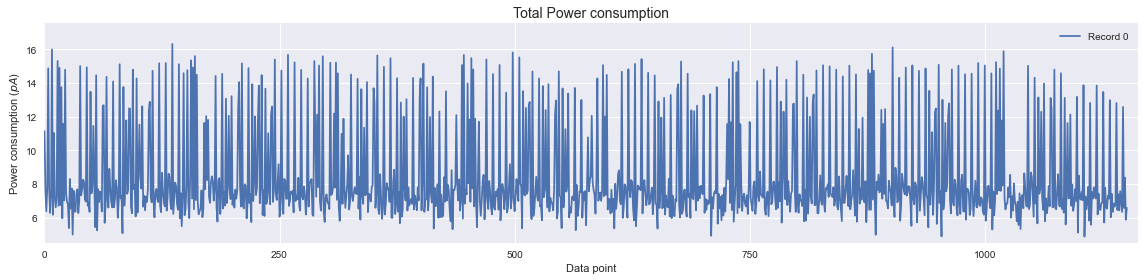

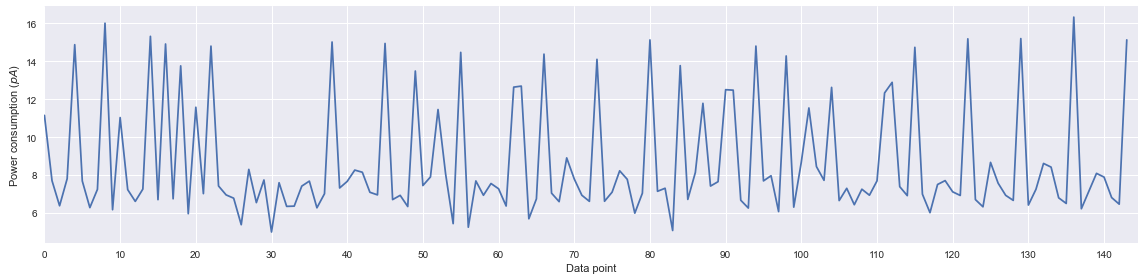

In [14]:
# Plot full power consumption through time
y = df.iloc[0][:-1]
X = np.arange(len(y))

# Plot line
plt.figure(figsize=(16, 4))
plt.plot(X, y, '-', label='Record 0') # colors: b,g,r,c,m,y,k,w
plt.xlim(X.min(), X.max()*1.01)
plt.ylim(y.min()*0.925, y.max()*1.075)
plt.xticks(np.arange(0, len(y)+1, 250))
# plt.yticks(np.arange(6, 16.1, 2))

# Set labels
plt.legend() # loc='best', 'upper right', 'lower left', ...
plt.xlabel('Data point')
plt.ylabel('Power consumption ($pA$)')
plt.title('Total Power consumption', fontsize=14)

# plt.savefig(f'Results/Other/power_consumption_total_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.png', dpi=200)
plt.show()

# Plot power consumption of one row through time
line_length = int(np.ceil(m * (power_product_gates.shape[1] + power_sum_gates.shape[1]) / sampling_interval))
X = np.arange(line_length)
y = df.iloc[0][:line_length]

# Plot line
plt.figure(figsize=(16, 4))
plt.plot(X, y, '-', label='Record 0') # colors: b,g,r,c,m,y,k,w
plt.xlim(X.min(), X.max()*1.01)
# plt.ylim(y.min()*0.925, y.max()*1.05)
plt.xticks(np.arange(0, line_length+1, 10))
# plt.yticks(np.arange(6, 16.1, 2))

# Set labels
# plt.legend() # loc='best', 'upper right', 'lower left', ...
plt.xlabel('Data point')
plt.ylabel('Power consumption ($pA$)')
# plt.title('Power consumption of one row', fontsize=14)

plt.savefig(f'Results/Other/power_consumption_one_row_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.png', dpi=200)
plt.show()

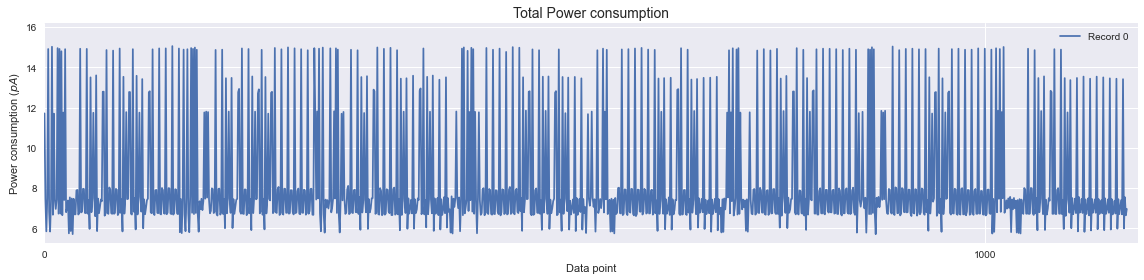

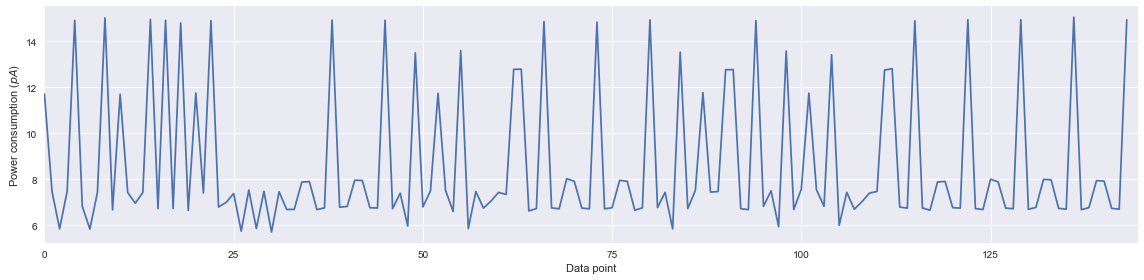

In [25]:
# FULL RESOLUTION (1 gate) ----- # Plot full power consumption through time
y = df.iloc[0][:-1]
X = np.arange(len(y))

# Plot line
plt.figure(figsize=(16, 4))
plt.plot(X, y, '-', label='Record 0') # colors: b,g,r,c,m,y,k,w
plt.xlim(X.min(), X.max()*1.01)
plt.ylim(y.min()*0.925, y.max()*1.075)
plt.xticks(np.arange(0, len(y)+1, 1000))
# plt.yticks(np.arange(6, 16.1, 2))

# Set labels
plt.legend() # loc='best', 'upper right', 'lower left', ...
plt.xlabel('Data point')
plt.ylabel('Power consumption ($pA$)')
plt.title('Total Power consumption', fontsize=14)

# plt.savefig(f'Results/Other/power_consumption_total_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.png', dpi=200)
plt.show()

# Plot power consumption of one row through time
line_length = m * (power_product_gates.shape[1] + power_sum_gates.shape[1])
X = np.arange(line_length)
y = df.iloc[0][:line_length]

# Plot line
plt.figure(figsize=(16, 4))
plt.plot(X, y, '-', label='Record 0') # colors: b,g,r,c,m,y,k,w
plt.xlim(X.min(), X.max()*1.01)
# plt.ylim(y.min()*0.925, y.max()*1.075)
plt.xticks(np.arange(0, line_length+1, 25))
# plt.yticks(np.arange(6, 16.1, 2))

# Set labels
# plt.legend() # loc='best', 'upper right', 'lower left', ...
plt.xlabel('Data point')
plt.ylabel('Power consumption ($pA$)')
# plt.title('Power consumption of one row', fontsize=14)

plt.savefig(f'Results/Other/power_consumption_one_row_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.png', dpi=200)
plt.show()

In [ ]:
# # Drop columns with equal values (worthless with noise)
# def duplicate_columns(df):
#     groups = df.columns.to_series().groupby(df.dtypes).groups
#     dups = []
#     for t, v in groups.items():
#         dcols = df[v].to_dict(orient='list')
#         vs = list(dcols.values())
#         ks = list(dcols.keys())
#         for i in range(len(vs)):
#             for j in range(i+1, len(vs)):
#                 if vs[i] == vs[j]: 
#                     dups.append(ks[i])
#                     break
#     if dups: print('Duplicate columns:', *dups)
#     return dups

# df.drop(duplicate_columns(df), axis=1, inplace=True)
# np.around(df, 3)

In [ ]:
# # Check some trends in data (turn off numba engine first)
# pd.set_option('compute.use_numba', False)
# df2 = df.copy()
# df2.intent = [90] # More_1_than_0
# display(df2)
# pd.set_option('compute.use_numba', True)

In [ ]:
# # Generate pandas profiling report
# profile = ProfileReport(
#     df, title=f'More_1s_or_0s Low_Sampling={sampling_interval}_Noisy_Power_per_Gate noise_std={noise_std} Dataset Report',
#     explorative=True)
# # profile.to_widgets()
# profile.to_file(f'Docs/More_1s_or_0s_-_Low_Sampling={sampling_interval}_Noisy_Power_per_Gate_noisestd={noise_std}_report.html')

### Split data

- CV splitters: integer seed (so splits are the same & we can compare folds)

- Estimators: RandomState seed (so estimator is robust to randomness)

In [141]:
# Split data into training & test set
X = np.asarray(df.drop(class_index, axis=1), order='C')
y = np.asarray(df[class_index], order='C')
assert X.flags['C_CONTIGUOUS']
assert y.flags['C_CONTIGUOUS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)

print(f'Trues in train set: {y_train.mean():.2%}\n'
      f'Trues in test set:  {y_test.mean():.2%}')
np.shape(X_train), np.shape(X_test)

Trues in train set: 42.46%
Trues in test set:  42.45%


((8000, 615), (2000, 615))

In [ ]:
# Save test set
test_set = {'X_test': X_test,
            'y_test': y_test}
joblib.dump(test_set, f'Data/test_set_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib', compress=3)

In [142]:
# Delete unused variables to free some memory
del df, data_low_sampling, X, y

## Classifiers

### Functions to train & test models

#### TuneGridSearchCV (very slow)

In [ ]:
from tune_sklearn import TuneGridSearchCV
from ray.tune.schedulers import ASHAScheduler

# Perform a grid search with k-fold cross validation & early stopping
def Grid_Search(model, param_grid, X_train, y_train, early_stopping=False):
    pipe = Pipeline([('scaler', None), ('model', model)])
    cv   = StratifiedKFold(5, shuffle=True, random_state=seed)
    if early_stopping:
        max_iters = 5
        early_stopping = ASHAScheduler(max_t=max_iters, reduction_factor=2)
    else:
        max_iters = 1
        early_stopping = False

    grid_search = TuneGridSearchCV(pipe, param_grid, scoring='accuracy', refit=True, early_stopping=early_stopping,
                                   max_iters=max_iters, cv=cv, n_jobs=-1, use_gpu=False, verbose=1)

    start_time = timeit.default_timer()
    # with joblib.parallel_backend('multiprocessing', n_jobs=-1):
    grid_search.fit(X_train, y_train)
    delta_time = timedelta(seconds=round(timeit.default_timer()-start_time))

    # Print best accuracy & parameters
    print(f"Best pars:     {grid_search.best_params_}\n"
          f"Best accuracy: {grid_search.best_score_:6.2%} +- {grid_search.cv_results_['std_test_score'][grid_search.best_index_]:6.3%}\n"
          f"Executed in:  {delta_time}")

    return grid_search.best_estimator_

In [ ]:
# Remove ray-tune leftovers after training
! rm -rf /tmp/ray/
! rm -rf ~/ray_results

#### GridSearchCV

In [59]:
from sklearn.model_selection import GridSearchCV

# Perform a grid search with k-fold cross validation
def Grid_Search(model, param_grid, X_train, y_train):
    pipe        = Pipeline([('scaler', None), ('model', model)])
    cv          = StratifiedKFold(5, shuffle=True, random_state=seed)
    grid_search = GridSearchCV(pipe, param_grid, scoring='accuracy', refit=True, cv=cv, n_jobs=-1, verbose=2)

    start_time = timeit.default_timer()
    with joblib.parallel_backend('multiprocessing', n_jobs=-1):
        grid_search.fit(X_train, y_train)
    delta_time = timedelta(seconds=round(timeit.default_timer()-start_time))

    # Print best accuracy & parameters
    print(f"\nBest pars:     {grid_search.best_params_}\n"
          f"Best accuracy: {grid_search.best_score_:6.2%} +- {grid_search.cv_results_['std_test_score'][grid_search.best_index_]:6.3%}\n"
          f"Executed in:  {delta_time}")

    return grid_search.best_estimator_

#### HalvingGridSearchCV (fastest)

In [217]:
# Perform a grid search with k-fold cross validation & successive halving
    # does not support multimetric scoring yet
def Grid_Search(model, param_grid, X_train, y_train, resource='n_samples'):
    pipe   = Pipeline([('scaler', None), ('model', model)])
    cv     = StratifiedKFold(5, shuffle=True, random_state=seed)
    factor = 3
    if resource == 'n_samples':
        max_resources = len(X_train) # resources to use in last iteration
        grid_points   = sum([np.prod([len(v) for v in param_grid[i].values()]) for i in range(len(param_grid))])
        min_resources = int(max(max_resources//factor**round(math.log(max_resources/150, factor)), # use ~150 rows on first iteration
                                max_resources//factor**math.floor(math.log(grid_points, factor)))) # exhaust resources
    elif resource == 'n_estimators':
        resource      = 'model__' + resource
        min_resources = 'exhaust'
        max_resources = model.n_estimators

    grid_search = HalvingGridSearchCV(pipe, param_grid, scoring='accuracy', refit=True, factor=factor-1e-8, resource=resource,
                                      min_resources=min_resources, max_resources=max_resources+1, cv=cv, return_train_score=False,
                                      n_jobs=-1, random_state=seed, verbose=1) # factor-eps & max_resources+1 due to rounding errors

    start_time = timeit.default_timer()
    with joblib.parallel_backend('multiprocessing', n_jobs=-1): # faster backend
        grid_search.fit(X_train, y_train)
    delta_time = timedelta(seconds=round(timeit.default_timer()-start_time))

    # Print best accuracy & parameters
    print(f"\nBest pars:     {grid_search.best_params_}\n"
          f"Best accuracy: {grid_search.best_score_:6.2%} +- {grid_search.cv_results_['std_test_score'][grid_search.best_index_]:6.3%}\n"
          f'Executed in:  {delta_time}')

    return grid_search.best_estimator_

In [30]:
# Get prediction statistics
def get_statistics(model, X_test, y_test, model_name, prob=False):
    print(f'Mean accuracy on test set: {model.score(X_test, y_test):6.2%}')
    if prob:
        y_prob = model.predict_proba(X_test)
        print(f'Mean probability:          {np.mean(np.max(y_prob, axis=1)):6.2%}')

    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    # print('\nConfusion matrix: \n', cm, '\n')
    print('\nReport:\n', classification_report(y_test, y_pred, digits=3))

    # Plot confusion matrix
    print('Confusion matrix:')
    fig, ax = plt.subplots(figsize=(3, 2))
    ConfusionMatrixDisplay(cm).plot(values_format='d', cmap='Blues', colorbar=False, ax=ax)
    ax.set(xlabel='Predicted label', ylabel='True label')
    ax.grid(False)
    plt.savefig(f'Results/Other/confusion_matrix_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.png', dpi=200)
    plt.show()

### Logistic regression

In [31]:
model = LogisticRegression(tol=1e-3, max_iter=1e4, n_jobs=-1, random_state=np.random.RandomState(seed), verbose=0)

# Perform a grid search with k-fold cross validation
param_grid = [{'scaler':         [None, MinMaxScaler((0, 1)), StandardScaler(), RobustScaler(quantile_range=(25., 75.))],
               'model__solver':  ['saga', 'lbfgs'],
               'model__penalty': ['none']},
              {'scaler':         [None, MinMaxScaler((0, 1)), StandardScaler(), RobustScaler(quantile_range=(25., 75.))],
               'model__solver':  ['saga'],
               'model__penalty': ['l1', 'l2'],
               'model__C':       np.logspace(2, -2, 5)},
              {'scaler':         [None, MinMaxScaler((0, 1)), StandardScaler(), RobustScaler(quantile_range=(25., 75.))],
               'model__solver':  ['lbfgs'],
               'model__penalty': ['l2'],
               'model__C':       np.logspace(2, -2, 5)}]
# pipe = Grid_Search(model, param_grid, X_train, y_train, early_stopping=True) # TuneGridSearchCV
pipe = Grid_Search(model, param_grid, X_train, y_train) # GridSearchCV, HalvingGridSearchCV

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 296
max_resources_: 8001
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 68
n_resources: 296
Fitting 5 folds for each of 68 candidates, totalling 340 fits
----------
iter: 1
n_candidates: 23
n_resources: 888
Fitting 5 folds for each of 23 candidates, totalling 115 fits
----------
iter: 2
n_candidates: 8
n_resources: 2664
Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------
iter: 3
n_candidates: 3
n_resources: 7992
Fitting 5 folds for each of 3 candidates, totalling 15 fits

Best pars:     {'model__C': 0.1, 'model__penalty': 'l1', 'model__solver': 'saga', 'scaler': None}
Best accuracy: 89.54% +- 1.219%
Executed in:  2:00:28


In [32]:
# Train with full training set
pipe.fit(X_train, y_train)

# Save model
model_name = 'LR1'
# joblib.dump(pipe, f'Results/Models/pipe_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

Mean accuracy on test set: 90.95%
Mean probability:          87.02%

Report:
               precision    recall  f1-score   support

       False      0.917     0.927     0.922      1151
        True      0.900     0.886     0.893       849

    accuracy                          0.909      2000
   macro avg      0.908     0.906     0.907      2000
weighted avg      0.909     0.909     0.909      2000

Confusion matrix:


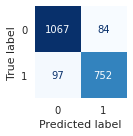

In [33]:
# Get prediction statistics
get_statistics(pipe, X_test, y_test, model_name, prob=True)

In [34]:
model = SGDClassifier(loss='log', learning_rate='adaptive', eta0=1., tol=1e-3, max_iter=1e4, n_jobs=-1,
                      random_state=np.random.RandomState(seed), verbose=0)

# Perform a grid search with k-fold cross validation
param_grid = [{'scaler':         [None, MinMaxScaler((0, 1)), StandardScaler(), RobustScaler(quantile_range=(25., 75.))],
               'model__penalty': ['l1', 'l2'],
               'model__alpha':   [0, *np.logspace(-5, 1, 7)],
               'model__eta0':    np.logspace(3, -3, 7)}]
# pipe = Grid_Search(model, param_grid, X_train, y_train, early_stopping=True) # TuneGridSearchCV
pipe = Grid_Search(model, param_grid, X_train, y_train) # GridSearchCV, HalvingGridSearchCV

n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 98
max_resources_: 8001
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 448
n_resources: 98
Fitting 5 folds for each of 448 candidates, totalling 2240 fits
----------
iter: 1
n_candidates: 150
n_resources: 294
Fitting 5 folds for each of 150 candidates, totalling 750 fits
----------
iter: 2
n_candidates: 50
n_resources: 882
Fitting 5 folds for each of 50 candidates, totalling 250 fits
----------
iter: 3
n_candidates: 17
n_resources: 2646
Fitting 5 folds for each of 17 candidates, totalling 85 fits
----------
iter: 4
n_candidates: 6
n_resources: 7938
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best pars:     {'model__alpha': 0.001, 'model__eta0': 0.001, 'model__penalty': 'l1', 'scaler': MinMaxScaler()}
Best accuracy: 93.02% +- 0.924%
Executed in:  0:18:07


In [35]:
# Train with full training set
pipe.fit(X_train, y_train)

# Save model
model_name = 'LR2'
# joblib.dump(pipe, f'Results/Models/pipe_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

Mean accuracy on test set: 93.55%
Mean probability:          84.26%

Report:
               precision    recall  f1-score   support

       False      0.941     0.948     0.944      1151
        True      0.929     0.919     0.924       849

    accuracy                          0.935      2000
   macro avg      0.935     0.933     0.934      2000
weighted avg      0.935     0.935     0.935      2000

Confusion matrix:


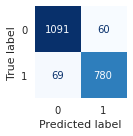

In [36]:
# Get prediction statistics
get_statistics(pipe, X_test, y_test, model_name, prob=True)

### SVM

In [37]:
model = SVC(probability=False, tol=1e-3, max_iter=-1, cache_size=45000, random_state=np.random.RandomState(seed), verbose=False)

# Perform a grid search with k-fold cross validation
param_grid = [#{'scaler':        [MinMaxScaler((-1, 1)), StandardScaler(), RobustScaler(quantile_range=(25., 75.))],
              #  'model__kernel': ['linear'],
              #  'model__C':      np.logspace(2, -2, 5)},
              {'scaler':        [MinMaxScaler((-1, 1)), StandardScaler(), RobustScaler(quantile_range=(25., 75.))],
               'model__kernel': ['rbf'],
               'model__C':      np.logspace(2, -2, 5),
               'model__gamma':  ['scale', 'auto']},
              {'scaler':        [MinMaxScaler((-1, 1)), StandardScaler(), RobustScaler(quantile_range=(25., 75.))],
               'model__kernel': ['poly'],
               'model__C':      np.logspace(2, -2, 5),
               'model__gamma':  ['scale', 'auto'],
               'model__degree': [3, 4],
               'model__coef0':  [-1, 0, 1]},
              # {'scaler':        [MinMaxScaler((-1, 1)), StandardScaler(), RobustScaler(quantile_range=(25., 75.))],
              #  'model__kernel': ['sigmoid'],
              #  'model__C':      np.logspace(2, -2, 5),
              #  'model__gamma':  ['scale', 'auto'],
              #  'model__coef0':  [-1, 0, 1]}
             ]
pipe = Grid_Search(model, param_grid, X_train, y_train) # TuneGridSearchCV, GridSearchCV, HalvingGridSearchCV

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 98
max_resources_: 8001
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 210
n_resources: 98
Fitting 5 folds for each of 210 candidates, totalling 1050 fits
----------
iter: 1
n_candidates: 70
n_resources: 294
Fitting 5 folds for each of 70 candidates, totalling 350 fits
----------
iter: 2
n_candidates: 24
n_resources: 882
Fitting 5 folds for each of 24 candidates, totalling 120 fits
----------
iter: 3
n_candidates: 8
n_resources: 2646
Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------
iter: 4
n_candidates: 3
n_resources: 7938
Fitting 5 folds for each of 3 candidates, totalling 15 fits

Best pars:     {'model__C': 100.0, 'model__coef0': 1, 'model__degree': 3, 'model__gamma': 'auto', 'model__kernel': 'poly', 'scaler': MinMaxScaler(feature_range=(-1, 1))}
Best accuracy: 81.25% +- 1.057%
Executed in:  0:05:11


In [38]:
# Train with full training set
pipe.fit(X_train, y_train)

# Save model
model_name = 'SVM'
# joblib.dump(pipe, f'Results/Models/pipe_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

Mean accuracy on test set: 84.45%

Report:
               precision    recall  f1-score   support

       False      0.858     0.875     0.866      1151
        True      0.826     0.803     0.814       849

    accuracy                          0.845      2000
   macro avg      0.842     0.839     0.840      2000
weighted avg      0.844     0.845     0.844      2000

Confusion matrix:


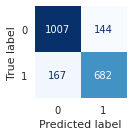

In [39]:
# Get prediction statistics
get_statistics(pipe, X_test, y_test, model_name)

In [40]:
model = LinearSVC(tol=1e-3, max_iter=1e4, random_state=np.random.RandomState(seed), verbose=0)

# Perform a grid search with k-fold cross validation
param_grid = [{'scaler': [MinMaxScaler((0, 1)), StandardScaler(), RobustScaler(quantile_range=(25., 75.))],
               'model__estimator__penalty': ['l2'],
               'model__estimator__loss':    ['hinge', 'squared_hinge'],
               'model__estimator__dual':    [True],
               'model__estimator__C':       np.logspace(2, -2, 5)},
              {'scaler': [MinMaxScaler((0, 1)), StandardScaler(), RobustScaler(quantile_range=(25., 75.))],
               'model__estimator__penalty': ['l1', 'l2'],
               'model__estimator__loss':    ['squared_hinge'],
               'model__estimator__dual':    [False],
               'model__estimator__C':       np.logspace(2, -2, 5)}]
pipe = Grid_Search(model, param_grid, X_train, y_train) # TuneGridSearchCV, GridSearchCV, HalvingGridSearchCV

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 296
max_resources_: 8001
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 60
n_resources: 296
Fitting 5 folds for each of 60 candidates, totalling 300 fits
----------
iter: 1
n_candidates: 20
n_resources: 888
Fitting 5 folds for each of 20 candidates, totalling 100 fits
----------
iter: 2
n_candidates: 7
n_resources: 2664
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 3
n_candidates: 3
n_resources: 7992
Fitting 5 folds for each of 3 candidates, totalling 15 fits

Best pars:     {'model__C': 0.1, 'model__dual': False, 'model__loss': 'squared_hinge', 'model__penalty': 'l1', 'scaler': MinMaxScaler()}
Best accuracy: 93.23% +- 0.689%
Executed in:  0:14:20


In [41]:
# Train with full training set
pipe.fit(X_train, y_train)

# Save model
model_name = 'SVM_linear1'
# joblib.dump(pipe, f'Results/Models/pipe_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

Mean accuracy on test set: 93.75%

Report:
               precision    recall  f1-score   support

       False      0.941     0.951     0.946      1151
        True      0.933     0.919     0.926       849

    accuracy                          0.938      2000
   macro avg      0.937     0.935     0.936      2000
weighted avg      0.937     0.938     0.937      2000

Confusion matrix:


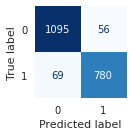

In [42]:
# Get prediction statistics
get_statistics(pipe, X_test, y_test, model_name)

In [43]:
model = SGDClassifier(loss='hinge', learning_rate='adaptive', eta0=1., tol=1e-3, max_iter=1e4, n_jobs=-1,
                      random_state=np.random.RandomState(seed), verbose=0)

# Perform a grid search with k-fold cross validation
param_grid = [{'scaler':         [MinMaxScaler((0, 1)), StandardScaler(), RobustScaler(quantile_range=(25., 75.))],
               'model__penalty': ['l1', 'l2'],
               'model__alpha':   [0, *np.logspace(-5, 1, 7)],
               'model__eta0':    np.logspace(3, -3, 7)}]
# pipe = Grid_Search(model, param_grid, X_train, y_train, early_stopping=True) # TuneGridSearchCV
pipe = Grid_Search(model, param_grid, X_train, y_train) # GridSearchCV, HalvingGridSearchCV

n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 98
max_resources_: 8001
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 448
n_resources: 98
Fitting 5 folds for each of 448 candidates, totalling 2240 fits
----------
iter: 1
n_candidates: 150
n_resources: 294
Fitting 5 folds for each of 150 candidates, totalling 750 fits
----------
iter: 2
n_candidates: 50
n_resources: 882
Fitting 5 folds for each of 50 candidates, totalling 250 fits
----------
iter: 3
n_candidates: 17
n_resources: 2646
Fitting 5 folds for each of 17 candidates, totalling 85 fits
----------
iter: 4
n_candidates: 6
n_resources: 7938
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best pars:     {'model__alpha': 0.001, 'model__eta0': 0.1, 'model__penalty': 'l1', 'scaler': MinMaxScaler()}
Best accuracy: 94.78% +- 0.327%
Executed in:  0:20:21


In [44]:
# Train with full training set
pipe.fit(X_train, y_train)

# Save model
model_name = 'SVM_linear2'
# joblib.dump(pipe, f'Results/Models/pipe_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

Mean accuracy on test set: 94.30%

Report:
               precision    recall  f1-score   support

       False      0.951     0.950     0.950      1151
        True      0.932     0.934     0.933       849

    accuracy                          0.943      2000
   macro avg      0.942     0.942     0.942      2000
weighted avg      0.943     0.943     0.943      2000

Confusion matrix:


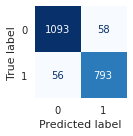

In [45]:
# Get prediction statistics
get_statistics(pipe, X_test, y_test, model_name)

### KNN

In [46]:
model = KNeighborsClassifier(n_jobs=-1)

# Perform a grid search with k-fold cross validation
param_grid = [{'scaler':             [None, MinMaxScaler((0, 1)), StandardScaler(), RobustScaler(quantile_range=(25., 75.))],
               'model__n_neighbors': np.arange(1, 22, 2), # odd nº
               'model__weights':     ['uniform', 'distance'],
               'model__metric':      ['manhattan', 'euclidean', 'chebyshev']}]
pipe = Grid_Search(model, param_grid, X_train, y_train) # TuneGridSearchCV, GridSearchCV, HalvingGridSearchCV

n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 98
max_resources_: 8001
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 264
n_resources: 98
Fitting 5 folds for each of 264 candidates, totalling 1320 fits


/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

----------
iter: 1
n_candidates: 88
n_resources: 294
Fitting 5 folds for each of 88 candidates, totalling 440 fits


/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

----------
iter: 2
n_candidates: 30
n_resources: 882
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

----------
iter: 3
n_candidates: 10
n_resources: 2646
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-

/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)


----------
iter: 4
n_candidates: 4
n_resources: 7938
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)
/home/v082327/.local/lib/python3.6/site-packages/daal4py/sklearn/neighbors/_base.py:357: DataConversionWarning: A column-


Best pars:     {'model__metric': 'euclidean', 'model__n_neighbors': 21, 'model__weights': 'uniform', 'scaler': None}
Best accuracy: 56.95% +- 0.579%
Executed in:  0:08:58


In [47]:
# Train with full training set
pipe.fit(X_train, y_train)

# Save model
model_name = 'KNN'
# joblib.dump(pipe, f'Results/Models/pipe_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

Mean accuracy on test set: 57.75%
Mean probability:          61.19%

Report:
               precision    recall  f1-score   support

       False      0.600     0.798     0.685      1151
        True      0.504     0.278     0.358       849

    accuracy                          0.578      2000
   macro avg      0.552     0.538     0.522      2000
weighted avg      0.559     0.577     0.546      2000

Confusion matrix:


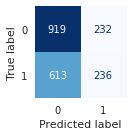

In [48]:
# Get prediction statistics
get_statistics(pipe, X_test, y_test, model_name, prob=True)

### Naïve Bayes

#### Gaussian NB

In [49]:
model = GaussianNB()

# Perform a grid search with k-fold cross validation
param_grid = [{'scaler':               [None, MinMaxScaler((0, 1)), StandardScaler(), RobustScaler(quantile_range=(25., 75.))],
               'model__var_smoothing': [0, *np.logspace(-10, 5, 16)]}]
# pipe = Grid_Search(model, param_grid, X_train, y_train, early_stopping=False) # TuneGridSearchCV
pipe = Grid_Search(model, param_grid, X_train, y_train) # GridSearchCV, HalvingGridSearchCV

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 296
max_resources_: 8001
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 68
n_resources: 296
Fitting 5 folds for each of 68 candidates, totalling 340 fits
----------
iter: 1
n_candidates: 23
n_resources: 888
Fitting 5 folds for each of 23 candidates, totalling 115 fits
----------
iter: 2
n_candidates: 8
n_resources: 2664
Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------
iter: 3
n_candidates: 3
n_resources: 7992
Fitting 5 folds for each of 3 candidates, totalling 15 fits

Best pars:     {'model__var_smoothing': 10.0, 'scaler': None}
Best accuracy: 65.63% +- 1.127%
Executed in:  0:01:22


In [50]:
# Train with full training set
pipe.fit(X_train, y_train)

# Save model
model_name = 'NB_gaussian'
# joblib.dump(pipe, f'Results/Models/pipe_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

Mean accuracy on test set: 65.30%
Mean probability:          66.65%

Report:
               precision    recall  f1-score   support

       False      0.643     0.893     0.748      1151
        True      0.693     0.327     0.445       849

    accuracy                          0.653      2000
   macro avg      0.668     0.610     0.596      2000
weighted avg      0.664     0.653     0.619      2000

Confusion matrix:


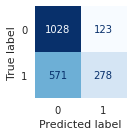

In [51]:
# Get prediction statistics
get_statistics(pipe, X_test, y_test, model_name, prob=True)

#### Multinomial NB

In [52]:
model = MultinomialNB() # does not work with negative values

# Perform a grid search with k-fold cross validation
param_grid = [{'scaler':           [None, MinMaxScaler((0, 1))],
               'model__alpha':     np.logspace(-10, 5, 16),
               'model__fit_prior': [False, True]}]
# pipe = Grid_Search(model, param_grid, X_train, y_train, early_stopping=False) # TuneGridSearchCV
pipe = Grid_Search(model, param_grid, X_train, y_train) # GridSearchCV, HalvingGridSearchCV

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 296
max_resources_: 8001
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 64
n_resources: 296
Fitting 5 folds for each of 64 candidates, totalling 320 fits
----------
iter: 1
n_candidates: 22
n_resources: 888
Fitting 5 folds for each of 22 candidates, totalling 110 fits
----------
iter: 2
n_candidates: 8
n_resources: 2664
Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------
iter: 3
n_candidates: 3
n_resources: 7992
Fitting 5 folds for each of 3 candidates, totalling 15 fits

Best pars:     {'model__alpha': 10.0, 'model__fit_prior': True, 'scaler': None}
Best accuracy: 65.09% +- 1.234%
Executed in:  0:00:26


In [53]:
# Train with full training set
pipe.fit(X_train, y_train)

# Save model
model_name = 'NB_multi'
# joblib.dump(pipe, f'Results/Models/pipe_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

pipe[1].n_features_in_, pipe[1].feature_count_

(18432,
 array([[61355.40333922, 32737.92250448, 29402.83407022, ...,
         31652.6588901 , 31749.18709805, 57430.65233993],
        [45360.01866223, 24004.28573512, 21787.06741242, ...,
         23652.17720428, 23587.62122559, 39438.10778465]]))

Mean accuracy on test set: 64.85%
Mean probability:          95.51%

Report:
               precision    recall  f1-score   support

       False      0.708     0.662     0.684      1151
        True      0.579     0.630     0.603       849

    accuracy                          0.648      2000
   macro avg      0.644     0.646     0.644      2000
weighted avg      0.653     0.648     0.650      2000

Confusion matrix:


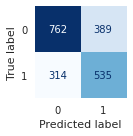

In [54]:
# Get prediction statistics
get_statistics(pipe, X_test, y_test, model_name, prob=True)

#### Categorical NB

In [55]:
model = CategoricalNB() # does not work with negative values

# Perform a grid search with k-fold cross validation
param_grid = [{'scaler':                [None], #MinMaxScaler((0, 1))],
               'model__alpha':          np.logspace(-10, 5, 16),
               'model__fit_prior':      [False, True],
               # 'model__min_categories': [*np.arange(int(0.1*N_vec), 19, -20), None]}]
               'model__min_categories': np.arange(int(0.1*N_vec), 19, -20)}]
# pipe = Grid_Search(model, param_grid, X_train, y_train, early_stopping=False) # TuneGridSearchCV
pipe = Grid_Search(model, param_grid, X_train, y_train) # GridSearchCV, HalvingGridSearchCV

n_iterations: 5
n_required_iterations: 7
n_possible_iterations: 5
min_resources_: 98
max_resources_: 8001
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1600
n_resources: 98
Fitting 5 folds for each of 1600 candidates, totalling 8000 fits
----------
iter: 1
n_candidates: 534
n_resources: 294
Fitting 5 folds for each of 534 candidates, totalling 2670 fits
----------
iter: 2
n_candidates: 178
n_resources: 882
Fitting 5 folds for each of 178 candidates, totalling 890 fits
----------
iter: 3
n_candidates: 60
n_resources: 2646
Fitting 5 folds for each of 60 candidates, totalling 300 fits
----------
iter: 4
n_candidates: 20
n_resources: 7938
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best pars:     {'model__alpha': 1.0, 'model__fit_prior': False, 'model__min_categories': 20, 'scaler': None}
Best accuracy: 62.55% +- 0.681%
Executed in:  0:51:45


In [56]:
# Train with full training set
pipe.fit(X_train, y_train)

# Save model
model_name = 'NB_cat'
# joblib.dump(pipe, f'Results/Models/pipe_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

pipe[1].n_features_in_, pipe[1].n_categories_

(18432, array([20, 20, 20, ..., 20, 20, 20]))

Mean accuracy on test set: 62.75%
Mean probability:          98.43%

Report:
               precision    recall  f1-score   support

       False      0.621     0.903     0.736      1151
        True      0.659     0.254     0.367       849

    accuracy                          0.627      2000
   macro avg      0.640     0.579     0.552      2000
weighted avg      0.637     0.627     0.579      2000

Confusion matrix:


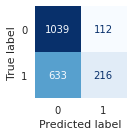

In [57]:
# Get prediction statistics
get_statistics(pipe, X_test, y_test, model_name, prob=True)

### Decision tree


------ 0 ------

n_iterations: 5
n_required_iterations: 7
n_possible_iterations: 5
min_resources_: 98
max_resources_: 8001
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 768
n_resources: 98
Fitting 5 folds for each of 768 candidates, totalling 3840 fits
----------
iter: 1
n_candidates: 256
n_resources: 294
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
----------
iter: 2
n_candidates: 86
n_resources: 882
Fitting 5 folds for each of 86 candidates, totalling 430 fits
----------
iter: 3
n_candidates: 29
n_resources: 2646
Fitting 5 folds for each of 29 candidates, totalling 145 fits
----------
iter: 4
n_candidates: 10
n_resources: 7938
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best pars:     {'model__criterion': 'entropy', 'model__max_depth': 5, 'model__max_features': 0.1, 'model__min_impurity_decrease': 0.0001, 'scaler': MinMaxScaler()}
Best accuracy: 63.06% +- 0.578%
Executed in:  0:13:53

Mean accuracy on test set: 64.25%
M

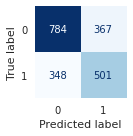


------ 1 ------

n_iterations: 5
n_required_iterations: 7
n_possible_iterations: 5
min_resources_: 98
max_resources_: 8001
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 768
n_resources: 98
Fitting 5 folds for each of 768 candidates, totalling 3840 fits
----------
iter: 1
n_candidates: 256
n_resources: 294
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
----------
iter: 2
n_candidates: 86
n_resources: 882
Fitting 5 folds for each of 86 candidates, totalling 430 fits
----------
iter: 3
n_candidates: 29
n_resources: 2646
Fitting 5 folds for each of 29 candidates, totalling 145 fits
----------
iter: 4
n_candidates: 10
n_resources: 7938
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best pars:     {'model__criterion': 'gini', 'model__max_depth': 5, 'model__max_features': 0.1, 'model__min_impurity_decrease': 1e-06, 'scaler': None}
Best accuracy: 61.92% +- 1.106%
Executed in:  0:12:02

Mean accuracy on test set: 62.05%
Mean probabilit

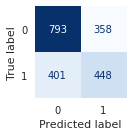


------ 2 ------

n_iterations: 5
n_required_iterations: 7
n_possible_iterations: 5
min_resources_: 98
max_resources_: 8001
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 768
n_resources: 98
Fitting 5 folds for each of 768 candidates, totalling 3840 fits
----------
iter: 1
n_candidates: 256
n_resources: 294
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
----------
iter: 2
n_candidates: 86
n_resources: 882
Fitting 5 folds for each of 86 candidates, totalling 430 fits
----------
iter: 3
n_candidates: 29
n_resources: 2646
Fitting 5 folds for each of 29 candidates, totalling 145 fits
----------
iter: 4
n_candidates: 10
n_resources: 7938
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best pars:     {'model__criterion': 'gini', 'model__max_depth': 5, 'model__max_features': 0.5, 'model__min_impurity_decrease': 0.001, 'scaler': MinMaxScaler()}
Best accuracy: 61.30% +- 1.617%
Executed in:  0:22:39

Mean accuracy on test set: 62.70%
Mean 

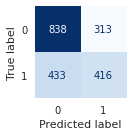


------ 3 ------

n_iterations: 5
n_required_iterations: 7
n_possible_iterations: 5
min_resources_: 98
max_resources_: 8001
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 768
n_resources: 98
Fitting 5 folds for each of 768 candidates, totalling 3840 fits
----------
iter: 1
n_candidates: 256
n_resources: 294
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
----------
iter: 2
n_candidates: 86
n_resources: 882
Fitting 5 folds for each of 86 candidates, totalling 430 fits
----------
iter: 3
n_candidates: 29
n_resources: 2646
Fitting 5 folds for each of 29 candidates, totalling 145 fits
----------
iter: 4
n_candidates: 10
n_resources: 7938
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best pars:     {'model__criterion': 'gini', 'model__max_depth': 10, 'model__max_features': 0.5, 'model__min_impurity_decrease': 0.01, 'scaler': StandardScaler()}
Best accuracy: 56.84% +- 1.256%
Executed in:  0:17:18

Mean accuracy on test set: 57.60%
Mea

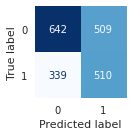


------ 4 ------

n_iterations: 5
n_required_iterations: 7
n_possible_iterations: 5
min_resources_: 98
max_resources_: 8001
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 768
n_resources: 98
Fitting 5 folds for each of 768 candidates, totalling 3840 fits
----------
iter: 1
n_candidates: 256
n_resources: 294
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
----------
iter: 2
n_candidates: 86
n_resources: 882
Fitting 5 folds for each of 86 candidates, totalling 430 fits
----------
iter: 3
n_candidates: 29
n_resources: 2646
Fitting 5 folds for each of 29 candidates, totalling 145 fits
----------
iter: 4
n_candidates: 10
n_resources: 7938
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best pars:     {'model__criterion': 'entropy', 'model__max_depth': 5, 'model__max_features': 0.1, 'model__min_impurity_decrease': 1e-06, 'scaler': RobustScaler()}
Best accuracy: 62.37% +- 1.364%
Executed in:  0:14:51

Mean accuracy on test set: 63.35%
Me

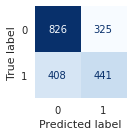


------ 5 ------

n_iterations: 5
n_required_iterations: 7
n_possible_iterations: 5
min_resources_: 98
max_resources_: 8001
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 768
n_resources: 98
Fitting 5 folds for each of 768 candidates, totalling 3840 fits
----------
iter: 1
n_candidates: 256
n_resources: 294
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
----------
iter: 2
n_candidates: 86
n_resources: 882
Fitting 5 folds for each of 86 candidates, totalling 430 fits
----------
iter: 3
n_candidates: 29
n_resources: 2646
Fitting 5 folds for each of 29 candidates, totalling 145 fits
----------
iter: 4
n_candidates: 10
n_resources: 7938
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best pars:     {'model__criterion': 'gini', 'model__max_depth': 10, 'model__max_features': 0.1, 'model__min_impurity_decrease': 0.01, 'scaler': MinMaxScaler()}
Best accuracy: 56.89% +- 0.989%
Executed in:  0:13:22

Mean accuracy on test set: 57.55%
Mean 

/home/v082327/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/v082327/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/v082327/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


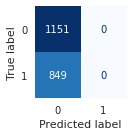


------ 6 ------

n_iterations: 5
n_required_iterations: 7
n_possible_iterations: 5
min_resources_: 98
max_resources_: 8001
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 768
n_resources: 98
Fitting 5 folds for each of 768 candidates, totalling 3840 fits
----------
iter: 1
n_candidates: 256
n_resources: 294
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
----------
iter: 2
n_candidates: 86
n_resources: 882
Fitting 5 folds for each of 86 candidates, totalling 430 fits
----------
iter: 3
n_candidates: 29
n_resources: 2646
Fitting 5 folds for each of 29 candidates, totalling 145 fits
----------
iter: 4
n_candidates: 10
n_resources: 7938
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best pars:     {'model__criterion': 'entropy', 'model__max_depth': 5, 'model__max_features': 0.3, 'model__min_impurity_decrease': 0, 'scaler': RobustScaler()}
Best accuracy: 62.43% +- 0.891%
Executed in:  0:22:42

Mean accuracy on test set: 61.95%
Mean p

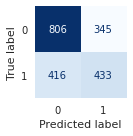


------ 7 ------

n_iterations: 5
n_required_iterations: 7
n_possible_iterations: 5
min_resources_: 98
max_resources_: 8001
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 768
n_resources: 98
Fitting 5 folds for each of 768 candidates, totalling 3840 fits
----------
iter: 1
n_candidates: 256
n_resources: 294
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
----------
iter: 2
n_candidates: 86
n_resources: 882
Fitting 5 folds for each of 86 candidates, totalling 430 fits
----------
iter: 3
n_candidates: 29
n_resources: 2646
Fitting 5 folds for each of 29 candidates, totalling 145 fits
----------
iter: 4
n_candidates: 10
n_resources: 7938
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best pars:     {'model__criterion': 'gini', 'model__max_depth': 5, 'model__max_features': 0.5, 'model__min_impurity_decrease': 1e-06, 'scaler': RobustScaler()}
Best accuracy: 62.33% +- 1.843%
Executed in:  0:21:55

Mean accuracy on test set: 62.05%
Mean 

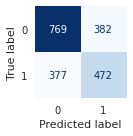


------ 8 ------

n_iterations: 5
n_required_iterations: 7
n_possible_iterations: 5
min_resources_: 98
max_resources_: 8001
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 768
n_resources: 98
Fitting 5 folds for each of 768 candidates, totalling 3840 fits
----------
iter: 1
n_candidates: 256
n_resources: 294
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
----------
iter: 2
n_candidates: 86
n_resources: 882
Fitting 5 folds for each of 86 candidates, totalling 430 fits
----------
iter: 3
n_candidates: 29
n_resources: 2646
Fitting 5 folds for each of 29 candidates, totalling 145 fits
----------
iter: 4
n_candidates: 10
n_resources: 7938
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best pars:     {'model__criterion': 'gini', 'model__max_depth': 5, 'model__max_features': 0.1, 'model__min_impurity_decrease': 0, 'scaler': RobustScaler()}
Best accuracy: 61.29% +- 0.915%
Executed in:  0:15:03

Mean accuracy on test set: 60.45%
Mean prob

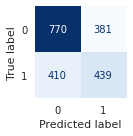


------ 9 ------

n_iterations: 5
n_required_iterations: 7
n_possible_iterations: 5
min_resources_: 98
max_resources_: 8001
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 768
n_resources: 98
Fitting 5 folds for each of 768 candidates, totalling 3840 fits
----------
iter: 1
n_candidates: 256
n_resources: 294
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
----------
iter: 2
n_candidates: 86
n_resources: 882
Fitting 5 folds for each of 86 candidates, totalling 430 fits
----------
iter: 3
n_candidates: 29
n_resources: 2646
Fitting 5 folds for each of 29 candidates, totalling 145 fits
----------
iter: 4
n_candidates: 10
n_resources: 7938
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best pars:     {'model__criterion': 'gini', 'model__max_depth': 5, 'model__max_features': 0.5, 'model__min_impurity_decrease': 1e-06, 'scaler': StandardScaler()}
Best accuracy: 62.77% +- 1.115%
Executed in:  0:18:19

Mean accuracy on test set: 61.00%
Mea

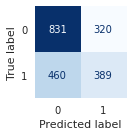

In [58]:
best = None, 0
for i in range(10):
    print(i, end=' ')
    model = DecisionTreeClassifier(random_state=np.random.RandomState(seed+i))

    # Perform a grid search with k-fold cross validation
    param_grid = [{'scaler': [None, MinMaxScaler((0, 1)), StandardScaler(), RobustScaler(quantile_range=(25., 75.))],
                   'model__criterion':             ['gini', 'entropy'],
                   'model__max_depth':             [5, 10, 20, None],
                   'model__max_features':          [0.1, 0.3, 0.5, None],
                   # 'model__max_leaf_nodes':      range(2, 21),
                   'model__min_impurity_decrease': [*np.logspace(-2, -6, 5), 0]}]
    pipe = Grid_Search(model, param_grid, X_train, y_train) # TuneGridSearchCV, GridSearchCV, HalvingGridSearchCV
    pipe.fit(X_train, y_train)

    acc = pipe.score(X_test, y_test)
    if acc > best[1]: best = i, acc
print(f'\nSeed: {seed+best[0]}\n'
      f'Mean accuracy on test set: {best[1]:6.2%}')

In [129]:
model = DecisionTreeClassifier(random_state=np.random.RandomState(seed))

# Perform a grid search with k-fold cross validation
param_grid = [{'scaler': [None, MinMaxScaler((0, 1)), StandardScaler(), RobustScaler(quantile_range=(25., 75.))],
               'model__criterion':             ['gini', 'entropy'],
               'model__max_depth':             [5, 10, 20, None],
               'model__max_features':          [0.1, 0.3, 0.5, None],
               # 'model__max_leaf_nodes':      range(2, 21),
               'model__min_impurity_decrease': [*np.logspace(-2, -6, 5), 0]}]
pipe = Grid_Search(model, param_grid, X_train, y_train) # TuneGridSearchCV, GridSearchCV, HalvingGridSearchCV

n_iterations: 5
n_required_iterations: 7
n_possible_iterations: 5
min_resources_: 98
max_resources_: 8001
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 768
n_resources: 98
Fitting 5 folds for each of 768 candidates, totalling 3840 fits
----------
iter: 1
n_candidates: 256
n_resources: 294
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
----------
iter: 2
n_candidates: 86
n_resources: 882
Fitting 5 folds for each of 86 candidates, totalling 430 fits
----------
iter: 3
n_candidates: 29
n_resources: 2646
Fitting 5 folds for each of 29 candidates, totalling 145 fits
----------
iter: 4
n_candidates: 10
n_resources: 7938
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best pars:     {'model__criterion': 'gini', 'model__max_depth': 5, 'model__max_features': 0.1, 'model__min_impurity_decrease': 0.0001, 'scaler': StandardScaler()}
Best accuracy: 65.24% +- 1.642%
Executed in:  0:00:22


In [130]:
# # Fine-tune min_impurity_decrease hyperparameter
# if pipe[1].min_impurity_decrease != 0.:
#     # Perform a grid search with k-fold cross validation
#     param_grid = [{'scaler':                       [pipe[0]],
#                    'model__min_impurity_decrease': pipe[1].min_impurity_decrease*np.asarray([0.2, 0.4, 0.6, 0.8, 1, 2, 4, 6, 8])}]
#     pipe = Grid_Search(pipe[1], param_grid, X_train, y_train) # TuneGridSearchCV, GridSearchCV, HalvingGridSearchCV

In [155]:
# # Fine-tune max_depth hyperparameter
# if pipe[1].max_depth != None:
#     # Perform a grid search with k-fold cross validation
#     param_grid = [{'scaler':           [pipe[0]],
#                    'model__max_depth': pipe[1].max_depth+np.arange(-4, 5)}]
#     pipe = Grid_Search(pipe[1], param_grid, X_train, y_train) # TuneGridSearchCV, GridSearchCV, HalvingGridSearchCV

In [173]:
# Train with full training set
pipe.fit(X_train, y_train)

# Save model
model_name = 'DT'
# joblib.dump(pipe, f'Results/Models/pipe_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

pipe[1].get_depth(), pipe[1].get_n_leaves()

(2, 4)

Mean accuracy on test set: 72.13%
Mean probability:          71.51%

Report:
               precision    recall  f1-score   support

       False      0.734     0.879     0.800      1177
        True      0.681     0.447     0.540       678

    accuracy                          0.721      1855
   macro avg      0.707     0.663     0.670      1855
weighted avg      0.715     0.721     0.705      1855

Confusion matrix:


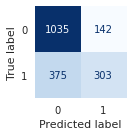

In [174]:
# Get prediction statistics
get_statistics(pipe, X_test, y_test, model_name, prob=True)

In [158]:
# # Draw tree
# from sklearn.tree import export_graphviz
# import graphviz

# dot_data = export_graphviz(pipe[1], feature_names=df.columns[:-1], class_names=['0','1'],
#                            filled=True, rounded=True, special_characters=True)
# graph = graphviz.Source(dot_data)
# graph.render(f'Results/Other/DT_{nb_name}_low_sampling={sampling_interval}_noisy_power_per_gate_noisestd={noise_std}', cleanup=True)
# graph

### Random forest

In [59]:
model = RandomForestClassifier(n_estimators=243, n_jobs=-1, random_state=np.random.RandomState(seed), verbose=0)

# Perform a grid search with k-fold cross validation
param_grid = [{'scaler': [None, MinMaxScaler((0, 1)), StandardScaler(), RobustScaler(quantile_range=(25., 75.))],
               'model__criterion':             ['gini', 'entropy'],
               'model__max_depth':             [5, None],
               'model__max_features':          [0.1, 0.5, None],
               # 'model__max_leaf_nodes':      range(2, 21),
               'model__min_impurity_decrease': np.logspace(-3, -5, 2)}]
# pipe = Grid_Search(model, param_grid, X_train, y_train, early_stopping=True) # TuneGridSearchCV
# pipe = Grid_Search(model, param_grid, X_train, y_train) # GridSearchCV
pipe = Grid_Search(model, param_grid, X_train, y_train, resource='n_estimators') # HalvingGridSearchCV

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 3
max_resources_: 244
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 96
n_resources: 3
Fitting 5 folds for each of 96 candidates, totalling 480 fits
----------
iter: 1
n_candidates: 32
n_resources: 9
Fitting 5 folds for each of 32 candidates, totalling 160 fits
----------
iter: 2
n_candidates: 11
n_resources: 27
Fitting 5 folds for each of 11 candidates, totalling 55 fits
----------
iter: 3
n_candidates: 4
n_resources: 81
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 4
n_candidates: 2
n_resources: 243
Fitting 5 folds for each of 2 candidates, totalling 10 fits

Best pars:     {'model__criterion': 'entropy', 'model__max_depth': 5, 'model__max_features': None, 'model__min_impurity_decrease': 1e-05, 'scaler': None, 'model__n_estimators': 243}
Best accuracy: 72.42% +- 1.350%
Executed in:  13:07:00


In [60]:
# Train with full training set
pipe.fit(X_train, y_train)

# Save model
model_name = 'RF'
# joblib.dump(pipe, f'Results/Models/pipe_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

Mean accuracy on test set: 75.10%
Mean probability:          59.35%

Report:
               precision    recall  f1-score   support

       False      0.708     0.964     0.817      1151
        True      0.905     0.462     0.612       849

    accuracy                          0.751      2000
   macro avg      0.807     0.713     0.714      2000
weighted avg      0.792     0.751     0.730      2000

Confusion matrix:


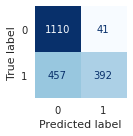

In [61]:
# Get prediction statistics
get_statistics(pipe, X_test, y_test, model_name, prob=True)

### Gradient-boosting

In [62]:
model = GradientBoostingClassifier(n_estimators=243, random_state=np.random.RandomState(seed), verbose=0)

# Perform a grid search with k-fold cross validation
param_grid = [{'scaler': [None, MinMaxScaler((0, 1)), StandardScaler(), RobustScaler(quantile_range=(25., 75.))],
               'model__loss':                  ['deviance', 'exponential'],
               'model__learning_rate':         [*np.logspace(-2, -1, 2), 0.9],
               'model__subsample':             [0.5, 1],
               'model__criterion':             ['friedman_mse'], #'mse'],
               'model__max_depth':             [5, None],
               'model__max_features':          [0.1, 0.5, None],
               # 'model__max_leaf_nodes':      range(2, 21),
               'model__min_impurity_decrease': np.logspace(-3, -5, 2)}]
# pipe = Grid_Search(model, param_grid, X_train, y_train, early_stopping=True) # TuneGridSearchCV
# pipe = Grid_Search(model, param_grid, X_train, y_train) # GridSearchCV
pipe = Grid_Search(model, param_grid, X_train, y_train, resource='n_estimators') # HalvingGridSearchCV

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 1
max_resources_: 244
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 576
n_resources: 1
Fitting 5 folds for each of 576 candidates, totalling 2880 fits
----------
iter: 1
n_candidates: 192
n_resources: 3
Fitting 5 folds for each of 192 candidates, totalling 960 fits
----------
iter: 2
n_candidates: 64
n_resources: 9
Fitting 5 folds for each of 64 candidates, totalling 320 fits
----------
iter: 3
n_candidates: 22
n_resources: 27
Fitting 5 folds for each of 22 candidates, totalling 110 fits
----------
iter: 4
n_candidates: 8
n_resources: 81
Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------
iter: 5
n_candidates: 3
n_resources: 243
Fitting 5 folds for each of 3 candidates, totalling 15 fits

Best pars:     {'model__criterion': 'friedman_mse', 'model__learning_rate': 0.9, 'model__loss': 'exponential', 'model__max_depth': 5, 'model__max_features': 0.5, 'model__min_

In [63]:
# Train with full training set
pipe.fit(X_train, y_train)

# Save model
model_name = 'GB'
# joblib.dump(pipe, f'Results/Models/pipe_{model_name}_{nb_name}_{n}x{m}_noise_std={noise_std}_sampling={sampling_interval}.joblib');

Mean accuracy on test set: 91.55%
Mean probability:          96.39%

Report:
               precision    recall  f1-score   support

       False      0.922     0.932     0.927      1151
        True      0.907     0.893     0.900       849

    accuracy                          0.915      2000
   macro avg      0.914     0.913     0.913      2000
weighted avg      0.915     0.915     0.915      2000

Confusion matrix:


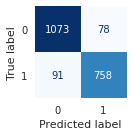

In [64]:
# Get prediction statistics
get_statistics(pipe, X_test, y_test, model_name, prob=True)